# Data Science Group Project Report 006-021
## Heart Disease Hungarian Data:
##### Members: 
- Jaden Lai (79465795)
- Percy Pham (70210562)
- Sydney Trim (86059649)

#### Introduction:
Heart disease is a leading cause of death worldwide associated with many variables. This project aims to identify patients most likely to experience heart problems by analyzing age, resting blood pressure, maximum heart rate, and cholestrol. To answer this question we will be analyzing the Heart Disease Data Set from the Hungarian Institute of Cardiology. This dataset provides fourteen attributes. However, we have selected four of them to find an answer to our question. We choose those four variables based on references from scientific articles and based on the type of values they held. We did not choose any categorical values such as sex, since categorical values do not work with the forward selection process which we use as one of our two ways to find the accuracy of our model. Additonally, we chose maximum heart rate, cholesterol, age, and resting blood pressure to focus on in our model due to the peer-reviewed, scientific articles that were backed up with good evidence and observations. We found articles claiming that the maximum heart rate and age of a patient increases risk of heart diseases, that resting blood pressure is positively associated with an increased risk, and lastly that cholesterol concentrations are connected to coronary heart disease.

#### Question: 
What kind of patients are most likely to experience heart disease using age, resting blood pressure, maximum heart rate, and cholestrol?

In [87]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

### Methods & Results

We begin by downloading, cleaning, and wrangling the data set where we assign column names, select our variables of interest, and filter missing cells; all the pre-processing needed to analyze this heart data set.

In [88]:
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data", "project.csv")
heart_disease_hungarian <- read_csv("project.csv", col_names = FALSE)
colnames(heart_disease_hungarian) <- c("age", "sex", "chest_pain", "resting_blood_pressure", "cholesterol",
                                       "fasting_blood_sugar", "resting_electrocardiographic_results", "maximum_heart_rate_achieved", 
                                       "exercise_induced_angina", "ST_depression",
                                       "slope_of_peak_exercise_ST_segment",
                                       "number_of_major_vessels", "thalassemia", "heart_disease_cases")

heart_disease_hungarian <- heart_disease_hungarian |>
             select(age, resting_blood_pressure, maximum_heart_rate_achieved,  cholesterol, heart_disease_cases) |>
             mutate(maximum_heart_rate_achieved = as.numeric(maximum_heart_rate_achieved)) |>
             mutate(cholesterol = as.numeric(cholesterol)) |>
             mutate(resting_blood_pressure = as.numeric(resting_blood_pressure)) |>
             mutate(heart_disease_cases = as.factor(heart_disease_cases)) |>
             filter(maximum_heart_rate_achieved != "NA") |>
             filter(resting_blood_pressure != "NA") |>
             filter(age != "NA") |>
             filter(resting_blood_pressure != "NA") |>
             filter(cholesterol != "?")

heart_disease_hungarian

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


age,resting_blood_pressure,maximum_heart_rate_achieved,cholesterol,heart_disease_cases
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
28,130,185,132,0
29,120,160,243,0
30,170,170,237,0
⋮,⋮,⋮,⋮,⋮
56,155,150,342,1
58,180,110,393,1
65,130,115,275,1


*Table 1: Cleaned heart disease data set*

##### Variable Explanation:
- Resting blood pressure: mmHg
- Cholesterol: mg/dl
- Heat disease cases: 1 = Positive, 0 = Negative

Now that we have cleaned our dataset, we perform a summary in preparation for exploratory data analysis.

In [89]:
 heart_disease_hungarian_summarize <- heart_disease_hungarian |> 
            filter(heart_disease_cases == 1) |>
            group_by(age) |>
            summarize(case_count = n()) |>
            arrange(case_count)

heart_disease_hungarian_summarize
tail(heart_disease_hungarian_summarize, 7)

age,case_count
<dbl>,<int>
31,1
32,1
33,1
⋮,⋮
48,8
52,8
54,8


age,case_count
<dbl>,<int>
56,5
58,5
46,6
⋮,⋮
48,8
52,8
54,8


*Table 2 & 3: Number of cases sorted by age in descending order*

##### Table Summary:
Organizing our data set, we can make an inference that heart disease cases are mostly found in older patients in the age range of 45-55,testing positive most frequently at the age of 54, and as early as 31.

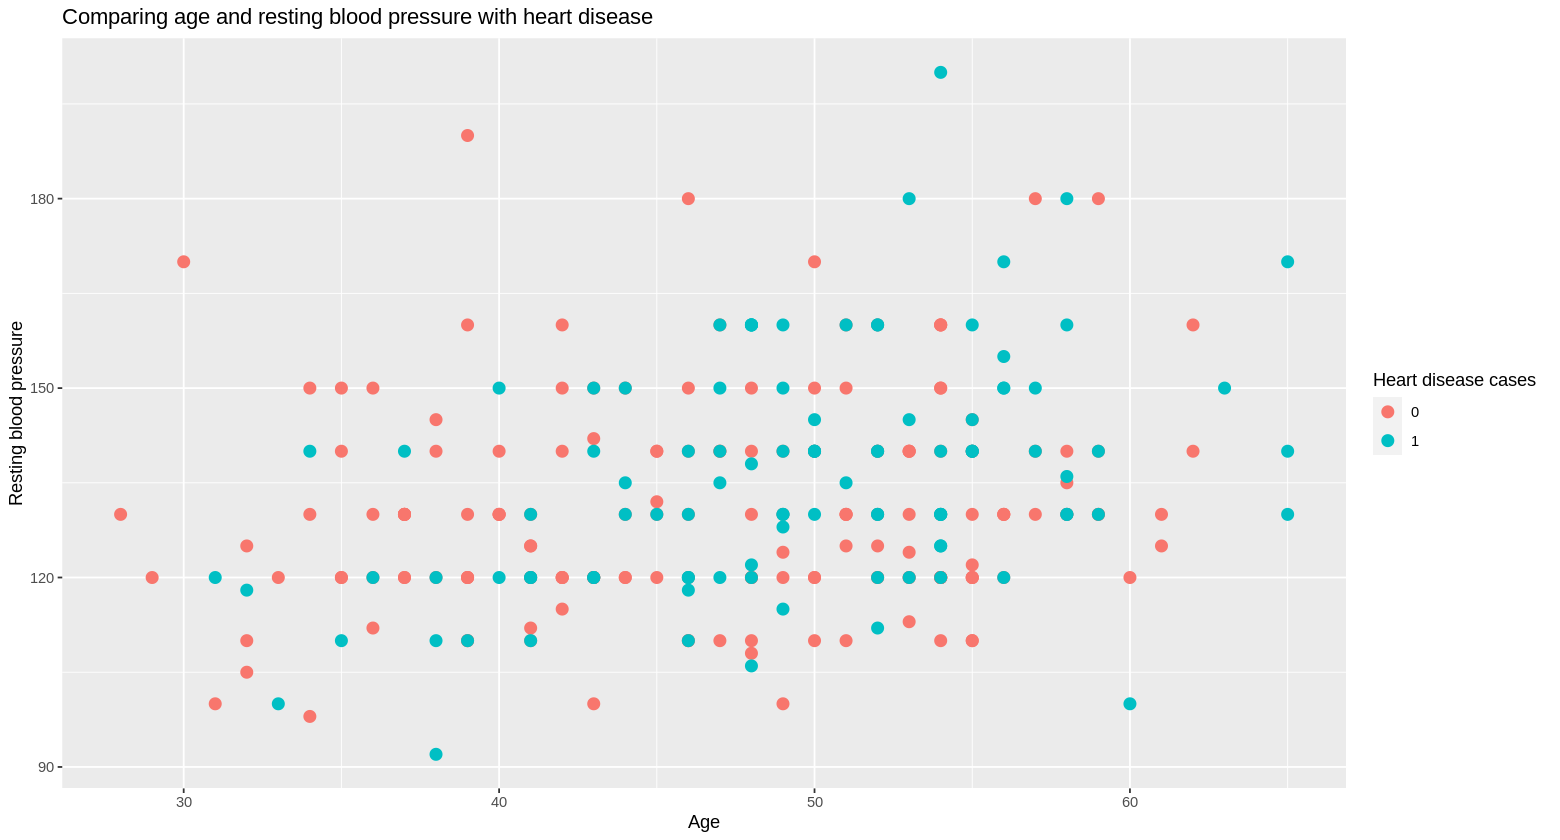

In [90]:
options(repr.plot.width = 13, repr.plot.height = 7)

heart_disease_plot <- heart_disease_hungarian |> 
    ggplot(aes(x = age, y = resting_blood_pressure, color = heart_disease_cases)) + 
        geom_point(size = 3) +
        labs(x = "Age", y = "Resting blood pressure", color = "Heart disease cases", title = "Comparing age and resting blood pressure with heart disease")

heart_disease_plot <- heart_disease_plot + 
       scale_fill_brewer(palette = "YlOrRd")
heart_disease_plot

*Plot 1: Plotting age vs resting blood pressure*

##### Explanation of Data Graph:
From reading the graph there seems to be no real relationship between the variables blood pressure and heart disease. Patients diagnosed with heart disease are predominantly found within the age range of 45-60 hence, we can establish the connection between age and heart disease cases.

##### Forward Selection:
We begin our analysis by finding the most accurate model and best predictors for heart disease, hence, our reason for performing the forward selection process. We first extract the column names, and then create an empty tibble to store the results.

In [91]:
names <- colnames(heart_disease_hungarian |> select(-heart_disease_cases))

accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

Next, we create our model specification and perform our 5-fold cross-validation. To perform forward selection, we also must store the number of predictors, and store the selected predictors.

In [92]:
set.seed(27)
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

heart_disease_vfold <- vfold_cv(heart_disease_hungarian, v = 5, strata = heart_disease_cases)

n_total <- length(names)

selected <- c()

The following code is taken directly from the textbook as forward selection goes beyond our knowledge in DSCI100

In [93]:
set.seed(27)
# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("heart_disease_cases", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        heart_disease_recipe <- recipe(as.formula(model_string), 
                                data = heart_disease_hungarian) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(heart_disease_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = heart_disease_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,heart_disease_cases ~ maximum_heart_rate_achieved,0.6673045
2,heart_disease_cases ~ maximum_heart_rate_achieved+cholesterol,0.6819147
3,heart_disease_cases ~ maximum_heart_rate_achieved+cholesterol+age,0.6816378
4,heart_disease_cases ~ maximum_heart_rate_achieved+cholesterol+age+resting_blood_pressure,0.6778769


*Table 4: Accuracy estimates produced using forward selection*

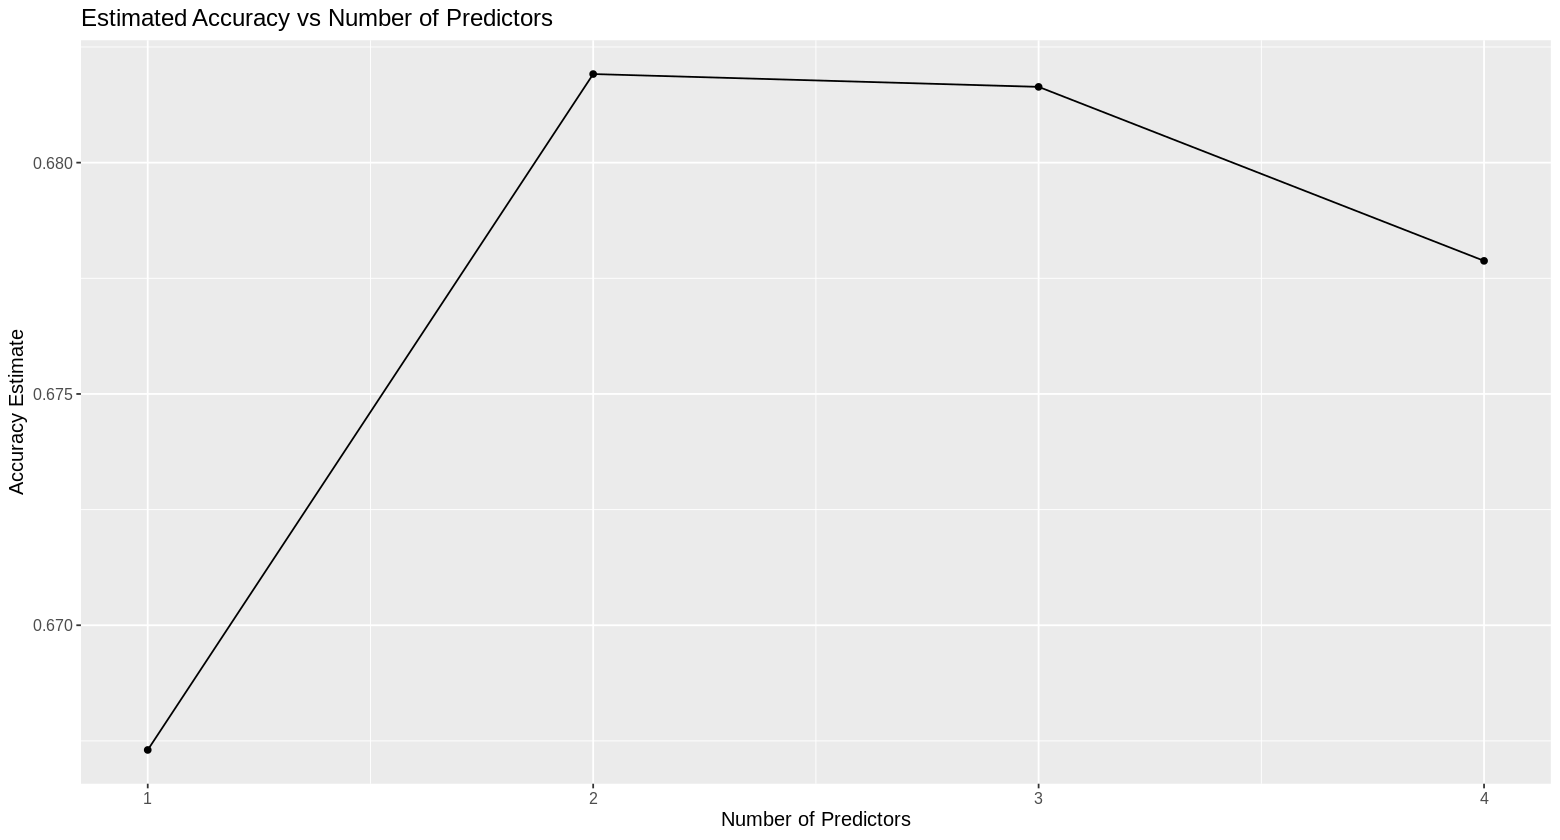

In [96]:
accuracy_vs_k <- ggplot(accuracies, aes(x = size, y = accuracy)) +
  geom_point() +
  geom_line() +
  labs(x = "Number of Predictors", y = "Accuracy Estimate", title = "Estimated Accuracy vs Number of Predictors") + 
  theme(text = element_text(size = 12))

accuracy_vs_k

*Plot 2: Finding the optimal number of predictors*

Notice that the number of predictors is estimated to be the most accurate at two predictors.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



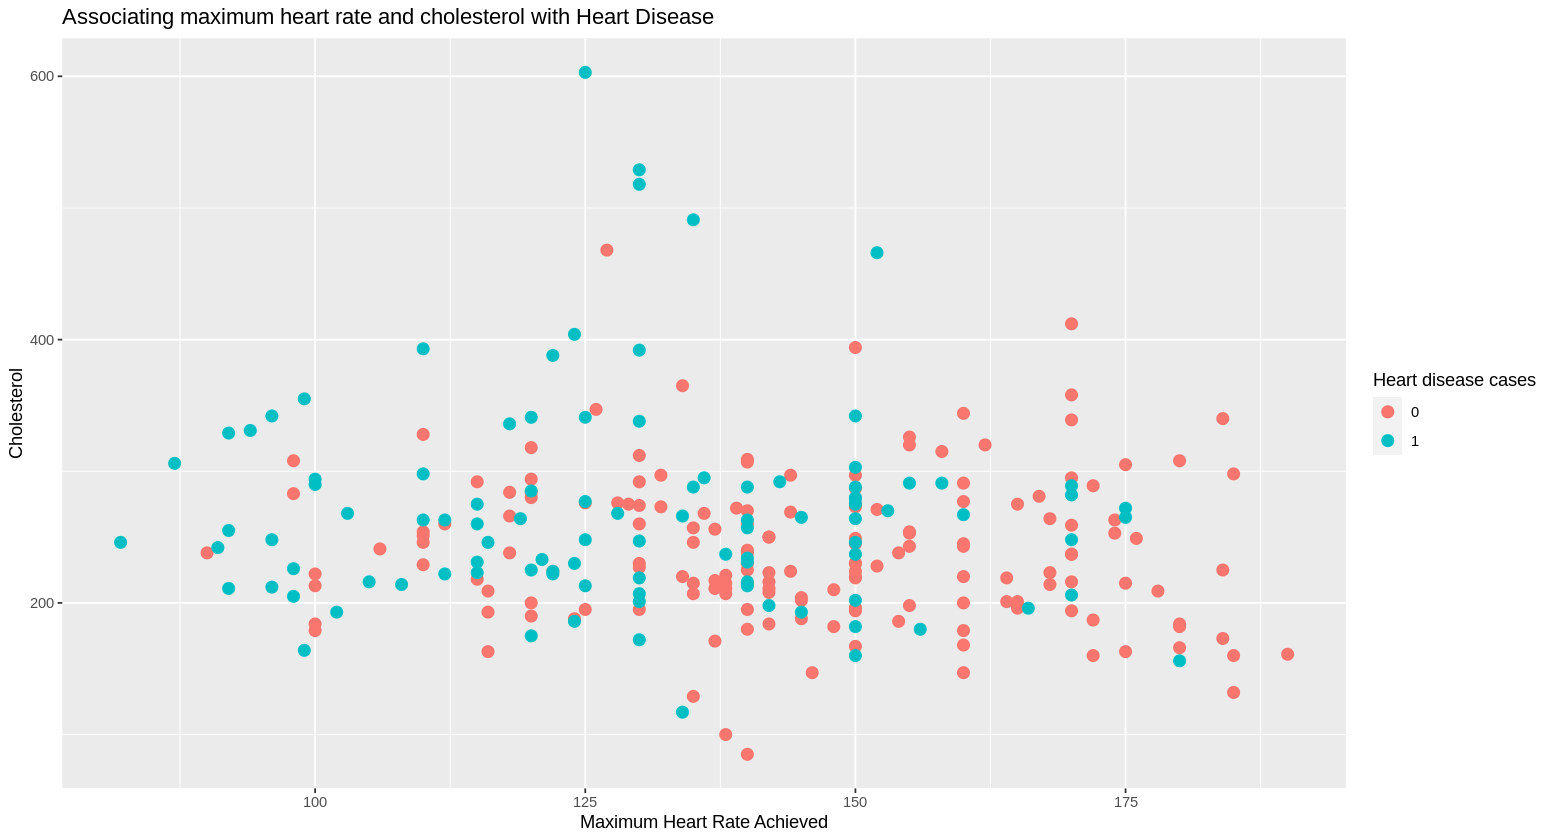

In [98]:
options(repr.plot.width = 13, repr.plot.height = 7)

heart_disease_plot_best <- heart_disease_hungarian |> 
    ggplot(aes(x = maximum_heart_rate_achieved, y = cholesterol, color = heart_disease_cases)) + 
        geom_point(size = 3) +
        labs(x = "Maximum Heart Rate Achieved", y = "Cholesterol", color = "Heart disease cases", title = "Associating maximum heart rate and cholesterol with Heart Disease")

heart_disease_plot <- heart_disease_plot + 
       scale_fill_brewer(palette = "YlOrRd")
heart_disease_plot_best

*Plot 3: Plotting the two highest accuracy estimate predictors*

Now that we have found the best accuracy estimate predictors to use, we will begin our cross-validation by splitting our data into a training and testing set.

In [99]:
set.seed(27)
hd_keep <- select(heart_disease_hungarian, maximum_heart_rate_achieved, cholesterol,heart_disease_cases)

hd_split <- initial_split(hd_keep, prop = 0.75, strata = heart_disease_cases)
hd_train <- training(hd_split)   
hd_test <- testing(hd_split)

We use vfold to split the training data for cross validation and a recipe that specifies our target and predictor variables with scaling.

In [41]:
hd_vfold <- vfold_cv(hd_train, v = 5, strata = heart_disease_cases)

hd_recipe <- recipe(heart_disease_cases ~ maximum_heart_rate_achieved + cholesterol, data = hd_train) |>
              step_scale(all_predictors()) |>
              step_center(all_predictors())

We now create a nearest neighbors workflow using our previously created recipe and model to estimate our classifiers accuacy for selected K values.

In [101]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

knn_results <- workflow() |>
                 add_recipe(hd_recipe) |>
                 add_model(knn_spec) |>
                 tune_grid(resamples = hd_vfold, grid = tibble(neighbors = c(2,3,4,5,6,7,8,9,10))) |>
                 collect_metrics() |>
                 filter(.metric == 'accuracy')

knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.5919512,5,0.02347474,Preprocessor1_Model1
3,accuracy,binary,0.6668293,5,0.01594556,Preprocessor1_Model2
4,accuracy,binary,0.6668293,5,0.01594556,Preprocessor1_Model3
⋮,⋮,⋮,⋮,⋮,⋮,⋮
8,accuracy,binary,0.7015854,5,0.017181278,Preprocessor1_Model7
9,accuracy,binary,0.6914634,5,0.006852639,Preprocessor1_Model8
10,accuracy,binary,0.6914634,5,0.006852639,Preprocessor1_Model9


*Table 5: Workflow with recipe and model to find accuarcy estimates using different K values*

Next, we plot our k values against their estimated accuracies in order to choose the most optimal k value.

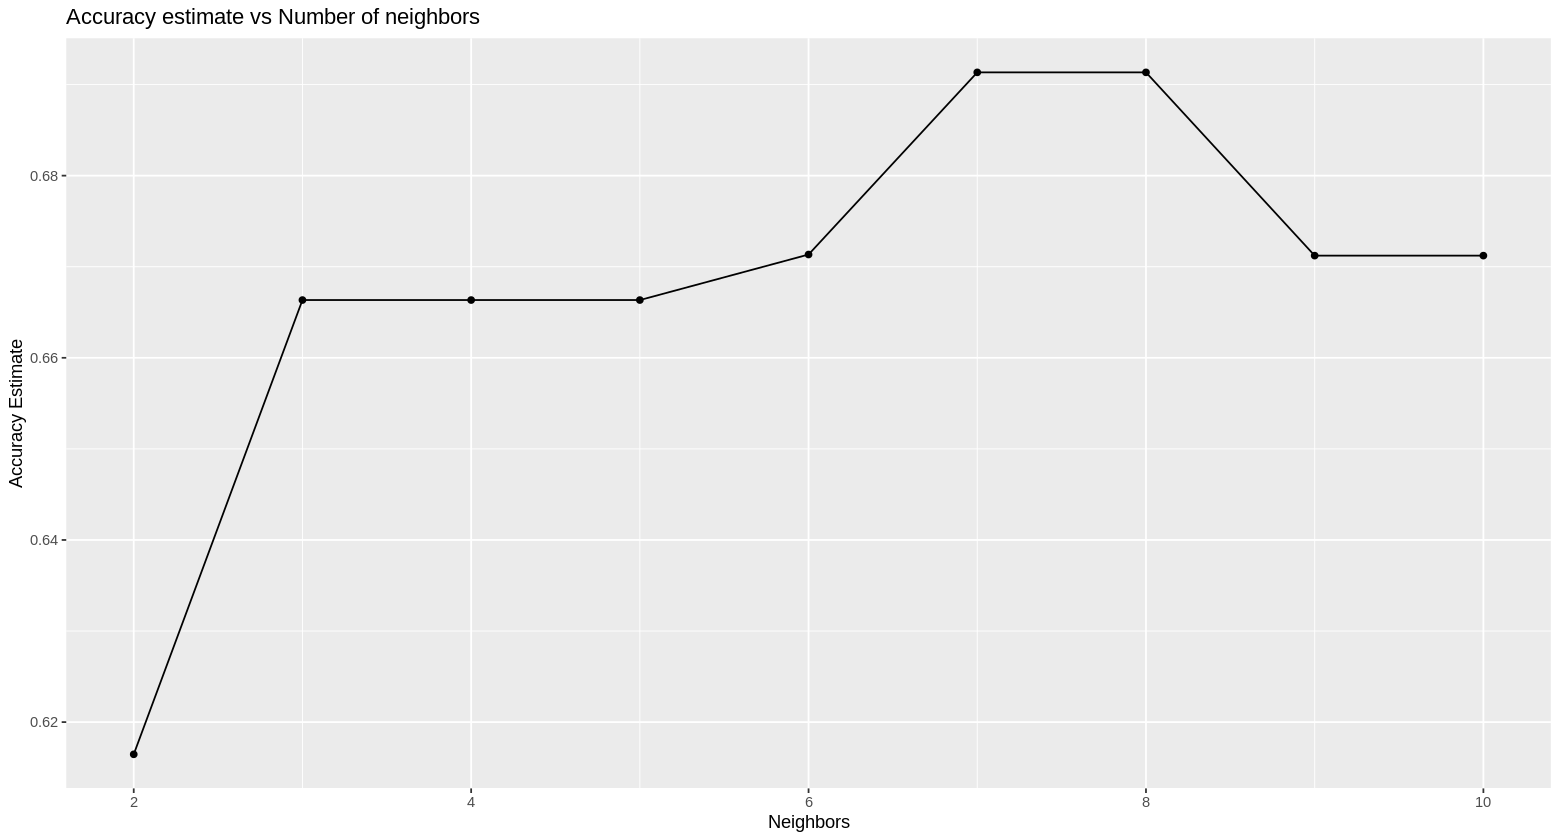

In [102]:
cross_val_plot <- ggplot(accuracy, aes(x = neighbors, y = mean)) +
                  geom_point() +
                  geom_line() +
                  labs(x = 'Neighbors', y = 'Accuracy Estimate', title = "Accuracy estimate vs Number of neighbors")

knn_results <- knn_results |> arrange(mean)

cross_val_plot

*Plot 4: Plotting neighbors vs accuracy estimate*

It appears the most optimal k value is k = 8. We also verify this by analyzing the accuracy estimated results sorted by the mean. Now we can create a new model specification with the best K value and re-train the classifier using fit(). After we have created our new model, we can evaluate the estimated accuracy of the new classifier on the test set using predict().

In [72]:
hd_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
       set_engine("kknn") |>
       set_mode("classification")

hd_fit <- workflow() |>
       add_recipe(hd_recipe) |>
       add_model(hd_spec) |>
       fit(data = hd_train)

hd_predictions <- predict(hd_fit , hd_test) |>
       bind_cols(hd_test)

hd_acc <- hd_predictions |> 
    metrics(truth = heart_disease_cases, estimate = .pred_class) |> 
    select(.metric, .estimate) |> 
    head(1)

hd_cm <- hd_predictions |> 
    conf_mat(truth = heart_disease_cases, estimate = .pred_class)

hd_acc
hd_cm

.metric,.estimate
<chr>,<dbl>
accuracy,0.6231884


          Truth
Prediction  0  1
         0 33 16
         1 10 10

*Table 6: Classification accuracy*

*Table 7: Confusion matrix*

Our model using the highest estimated accuracy predictors, and the highest estimated accuracy K value, yielded an accuracy estimate of 62%. In our confusion matrix, notice that 33 cases were predicted correctly as negative, while 10 were predicted correctly as positive for heart disease. 16 + 10 = 26 classifications however, were incorrectly predicted.

### Discussion:
#### What did we find?
From our findings in our forward selection model we found the most accurate predictors for patients with heart disease using forward selection. From the data table we found that the most accurate predictors for heart disease were the maximum heart rate and the cholesterol variables (as seen in our predictor graph, it was found that having two predictors was the most accurate). These predictors when combined had a accuracy percentage of 68.19%, while the other predictors values came close with accuracies of 68.16% (maximum heart rate, cholesterol, and age), 67.78% (maximum heart rate, cholesterol, age, and resting blood pressure), and the least accurate value being 66.73% (just maximum heart rate). Comparing our forward selection model to our final confusion metrics model, we can see that when our model predicts on new data, its accuracy decreases by about five percent. Although, there is a decrease in our accuracy between table 4 and table 7, the accuracy results are not skewed by a lot. Since our accuracy percentage is not the highest we can not accurately and consistently predict whether people have heart disease but we can make a good prediction whether a patient would need further examination or not. If patients test results come back with elevated levels of cholesterol and high maximum heart rate levels then based on our findings we can suggest those patients to further get tested.
#### Is this what we expected?
We expected to find associations such as an increase in age or any of our other predictors to be linked to increasing patients chances of obtaining heart disease. We in fact did observe that increased levels of cholesterol and maximum heart rate achieved, impacted the patients chances of heart disease. However, to our surprise age was not a predictor that helped us most accurately predict whether someone has heart disease. From plot one, we find that mostly older patients between the ages of 45 to 55 were more likely to test positive for heart disease but patients as early as 31 were also testing positive. Additionally, between models we expected our accuarcy to stay relatively the same. Our model accuarcy did stay within the 60 percentage accurate range but it still decreased from 68.19% to 62% which can be quite significant in a medical sense. Even with our accuarcy decreasing on testing data it can still be a good model to test if someone is predisposed or has early on set symptoms.
#### What impacts do these findings have?
Our findings can contribute to identifying whether or not patients should be further tested for heart disease based on their levels of cholesterol or maximum heart rate achieved. This is a preventative measure which could truly help the population of patients at high risk of heart disease or even the general community who naturally experience higher levels of out predictor variables. This research is done to contribute to the medical knowledge we already know and to advocate for health and prevention of this cardiovascular disease.
#### What future questions does this lead to?
Our findings lead to many questions such as: What other variables other than cholesterol and maximum heart rate achieved have the potential of leading people to become predisposed for heart disease? How can we make these tests more accessible for the people who are more at risk? What are the ideal levels of cholesterol and maximum heart rate that patients should strive to achieve if they are predisposed? How could people prevent heart disease with this new information?
### References:
- He, K., Chen, X., Shi, Z., Shi, S., Tian, Q., Hu, X., Song, R., Bai, K., Shi, W., Wang, J., Li, H., Ding, J., Geng, S., & Sheng, X. (2022). Relationship of resting heart rate and blood pressure with all-cause and cardiovascular disease mortality. Public Health, 208, 80–88. https://doi.org/10.1016/j.puhe.2022.03.020 
- Moran, A. E., Tzong, K. Y., Forouzanfar, M. H., Roth, G. A., Mensah, G. A., Ezzati, M., Murray, C. J. L., & Naghavi, M. (2014). Variations in ischemic heart disease burden by age, country, and income: the global burden of diseases, injuries, and risk factors 2010 study. Global Heart, 9(1), 91. https://doi.org/10.1016/j.gheart.2013.12.007 
- Park, C., Guallar, E., Linton, J. A., Lee, D.-C., Jang, Y., Son, D. K., Han, E.-J., Baek, S. J., Yun, Y. D., Jee, S. H., & Samet, J. M. (2013). Fasting glucose level and the risk of incident atherosclerotic cardiovascular diseases. Diabetes Care, 36(7), 1988–1993. https://doi.org/10.2337/dc12-1577 
- Liou L, Kaptoge S (2020) Association of small, dense LDL-cholesterol concentration and lipoprotein particle characteristics with coronary heart disease: A systematic review and meta-analysis. PLoS ONE 15(11): e0241993. https://doi.org/10.1371/journal.pone.0241993
- Han SH, Choi MS, Kim YM, Kim DM, Park HE, Hong JW, Kim SH, Shin YB, Lee BJ. Is Age-Predicted Maximal Heart Rate Applicable in Patients With Heart or Lung Disease? Ann Rehabil Med. 2022 Jun;46(3):133-141. doi: 10.5535/arm.21181. Epub 2022 Jun 30. PMID: 35793902; PMCID: PMC9263326. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9263326/